- 全データ使う(メモリリークとかを早めに対処したい

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
import json
import gc
import pickle 
import dask.dataframe as dd
import dask.array as da
from distributed import Client, LocalCluster
import psutil

from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append("../")
from src.model import MLModel, LightGBMModel
from src.validation import caluculate_metrics

# Config

In [3]:
class cfg:
    exp = "exp008"
    dataset_path = "../dataset/v5.0"
    feature_set = "all"
    
    model_params = {
        "objective": "regression",
        "boosting_type": "gbdt",
        "metric": "l2",
        "n_estimators": 20,
        # "max_depth": 5,
        "learning_rate": 0.01,
        "verbose": -1,
        # "feature_fraction": 0.1,
        # "seed": 42,
    }


In [4]:
# 実験用フォルダ作成    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)

with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set]

feature_set = feature_set[:]
print(f"feature col length: {len(feature_set)}")

feature col length: 2376


In [5]:
cluster = LocalCluster(memory_limit="16GB")
client = Client(cluster)

# Load Data

In [6]:
train = dd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era", "target"] + feature_set,
    # engine="pyarrow"
)

valid = dd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era", "target"] + feature_set,
    # engine="pyarrow"
)

# print(train.shape)
# display(train.head(2))

# print(valid.shape)
# display(valid.head(2))

# Preprocess

In [7]:
# target が 20 日、 era が週次なので重複してる。ので era を間引く
train["era_int"] = train["era"].astype(int)
valid["era_int"] = valid["era"].astype(int)

cond_train = train["era_int"] % 4 == 0
cond_valid = valid["era_int"] % 4 == 0

train = train.loc[cond_train]
valid = valid[~valid["target"].isnull()]
valid = valid.loc[cond_valid]

# display(train.head(2))
# display(valid.head(2))

# Training

In [8]:
features = feature_set
# features = features[:2]

In [9]:
model = LightGBMModel(
    model_params=cfg.model_params,
    client=client
)

train = client.persist(train)
valid = client.persist(valid)


In [10]:
print(type(train))
print(type(train[features]))
print(type(train["target"]))
print(type(valid))
print(type(valid[features]))
print(type(valid["target"]))

<class 'dask_expr._collection.DataFrame'>
<class 'dask_expr._collection.DataFrame'>
<class 'dask_expr._collection.Series'>
<class 'dask_expr._collection.DataFrame'>
<class 'dask_expr._collection.DataFrame'>
<class 'dask_expr._collection.Series'>


In [11]:

model.train(
    train[features],
    train["target"],
    eval_set=(valid[features], valid["target"]),
    early_stopping_rounds=10
)

model.save_model(os.path.join(cfg.exp, "model.pkl"))

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/dask.py:549: UserWarning: Parameter n_jobs will be ignored.
  _log_warning(f"Parameter {param_alias} will be ignored.")
2025-01-29 23:24:03,836 - distributed.worker - ERROR - Compute Failed
Key:       ('read_parquet-fef722324404eded5245f6607aefcc45', 0)
State:     executing
Function:  <dask.dataframe.io.parquet.core.ParquetFunctionWra
args:      ([{'piece': ('/home/kouya-takahashi/numerai/notebook/../dataset/v5.0/train.parquet', [0], [])}])
kwargs:    {}
Exception: "OSError('Malformed levels. min: 1 max: 16385 out of range.  Max Level: 1')"
Traceback: '  File "/home/kouya-takahashi/.local/lib/python3.9/site-packages/dask/dataframe/io/parquet/core.py", line 97, in __call__\n    return read_parquet_part(\n  File "/home/kouya-takahashi/.local/lib/python3.9/site-packages/dask/dataframe/io/parquet/core.py", line 645, in read_parquet_part\n    dfs = [\n  File "/home/kouya-takahashi/.local/lib/python3.9/site-packages/dask/dataf

AttributeError: 'Future' object has no attribute 'get_params'

In [ ]:
model.visualize_learning_curve()

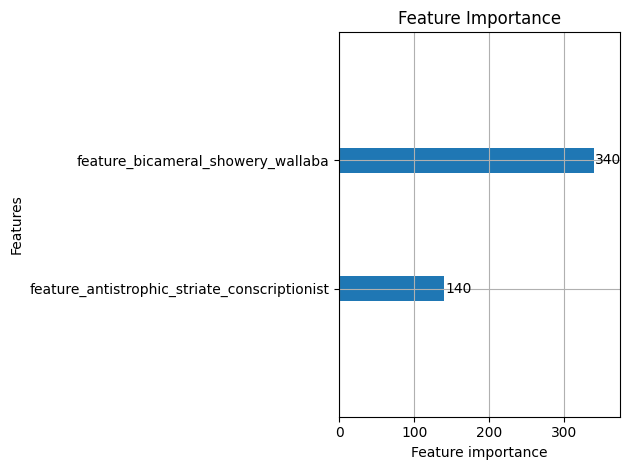

In [11]:
model.visualize_feature_importance()

# Validation

In [19]:
valid_pred = model.predict(valid[features])
valid_df = valid[["era", "target"]].compute()
valid_df["pred"] = valid_pred

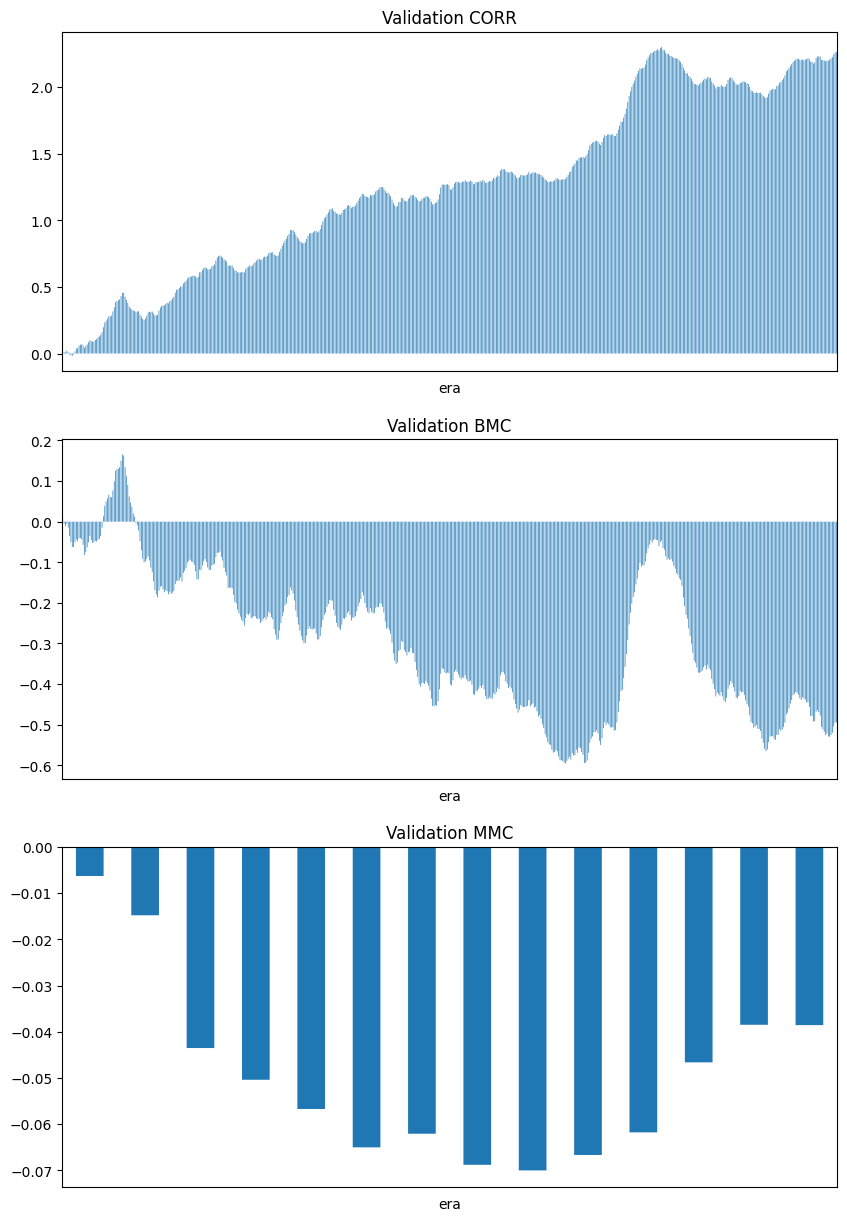

,corr_mean,corr_std,corr_shape,corr_max_drawdown,mmc_mean,mmc_std,mmc_shape,mmc_max_drawdown,bmc_mean,bmc_std,bmc_shape,bmc_max_drawdown
0,0.003958,0.01416,0.27952,0.383509,-0.002755,0.010277,-0.268048,0.063702,-0.000864,0.012197,-0.070838,0.760493


In [20]:
caluculate_metrics(cfg.dataset_path, valid_df)